# Aero Mesh

In [1]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [2]:
from jax import config
config.update("jax_enable_x64", True)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

import pyvista as pv
import jraph

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=2)

In [5]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [8]:
from emmd.utils import grid
from emmd.mmd import ImpCloudMMD, ergodic_metric
from emmd.transforms import Transform, ARD, DeepCK, GATKernel, DeepKernel
from emmd.kernels import RFF
from emmd.train import train_mmd_kernel, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.mesh import o3d_mesh_to_pv, o3d_mesh_to_graph, knn_graph, trajectory_graph, \
    plot_3d_trajectory_pv, point_in_mesh_fn, plot_multi_3d_traj_pv, downsample_o3d_mesh, traj_to_line

In [9]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [10]:
key = jax.random.PRNGKey(0)

## Data

In [11]:
aero = pv.examples.download_aero_bracket()
aero = aero.extract_surface()

In [12]:
aero_bounds = aero.bounds
aero_bounds = jnp.array(aero_bounds).reshape(3, 2).T
bounds = aero_bounds * 1.25

In [13]:
points = jnp.array(aero.points)
y = jnp.array(aero['von Mises stress'])
X_grid = grid(bounds, N=50, flatten=False)
X_flat = grid(bounds, N=50)

n_samples = 2500
sample_inds = jax.random.choice(key, jnp.arange(len(points)), shape=(n_samples,), replace=False, p=y / y.sum())
samples = points[sample_inds]
prob_s = y[sample_inds]
prob_s /= prob_s.max()

n_traj = 200
# traj_init = jnp.linspace(bounds[0], bounds[1], num=n_traj, endpoint=True)
traj_init = jax.random.choice(key, samples, shape=(n_traj,), replace=False)

In [14]:
# auxilary loss functions
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

point_in_mesh_approx = point_in_mesh_fn(aero, 80, bounds=bounds)

def aux_loss_fn(particles, beta=0.1):
    traj_loss = traj_loss_fn(particles)
    clipping_loss = point_in_mesh_approx(particles).sum() * beta
    return traj_loss + clipping_loss

In [15]:
def point_in_mesh_true(particles):
    points = pv.PointSet(particles)
    distances = points.compute_implicit_distance(aero)["implicit_distance"]
    return jnp.array(distances)

### Initial Metric and Plots

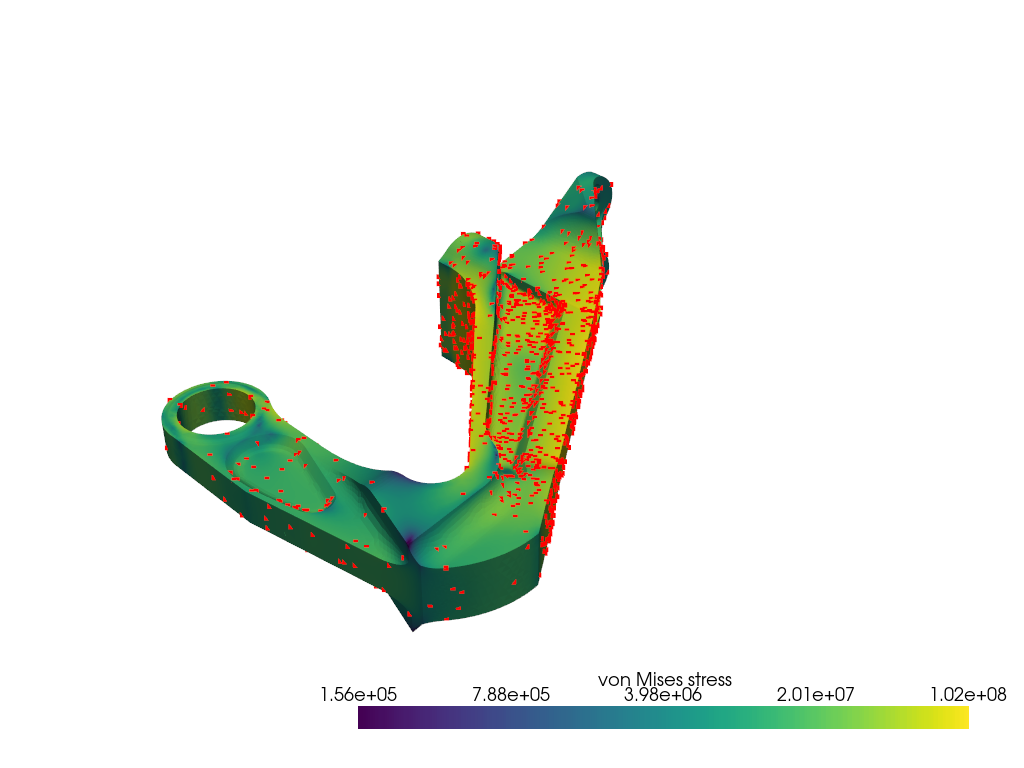

In [14]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(aero, scalars='von Mises stress', log_scale=True)
pl.add_points(pv.PointSet(samples), color='red')
pl.show(jupyter_backend='pythreejs')

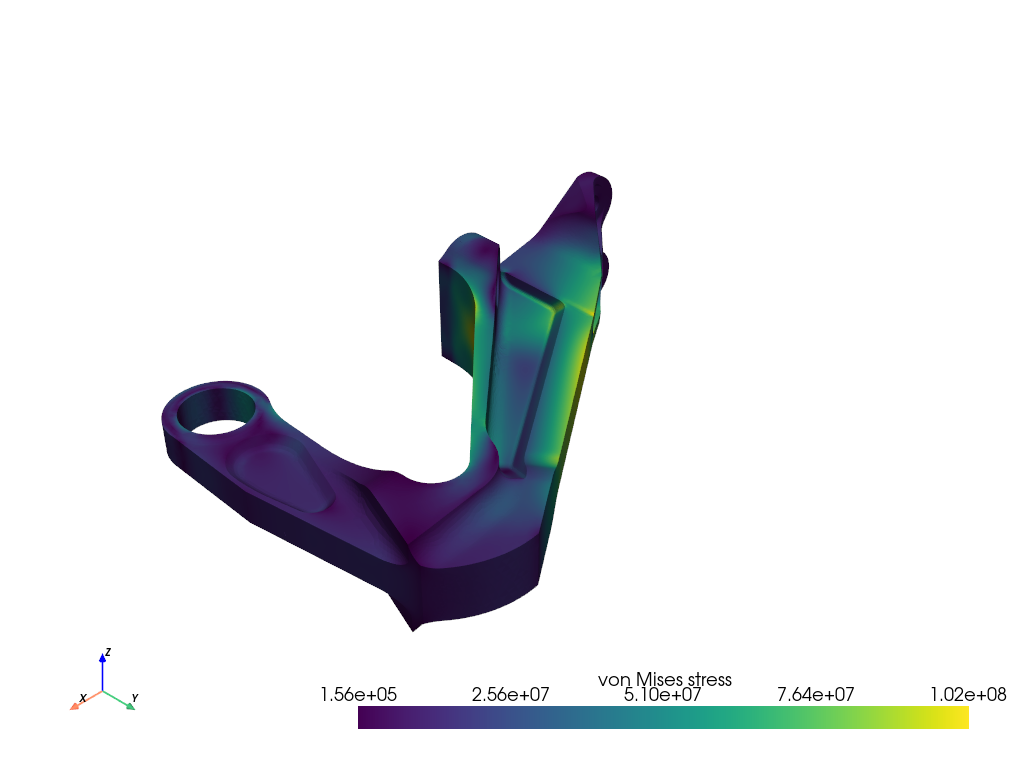

In [15]:
aero.plot(jupyter_backend='pythreejs', scalars='von Mises stress')

## Model Definitions

In [14]:
def train_rbf_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), ExpSquared())
    k_rff_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    mmd_init = ImpCloudMMD(k_init, traj_init)
    mmd_rff_init = ImpCloudMMD(k_rff_init, traj_init)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, to_train=lambda t: [t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_rff_init, samples, prob_samples, to_train=lambda t: [t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [t.k.transform.scale, t.z]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [15]:
def train_rff_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    k_init = Transform(ARD(ls_init), RFF(key, R=R, d=d))
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # power training
    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale],
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=lambda t: [t.k.kernel.w, t.k.transform.scale], 
        lowrank=True, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.kernel.w, t.k.transform.scale, t.z, t.q_params, #t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    return mmd_init, mmd_power, mmd_gp, mmd_score


In [16]:
def train_deep_kernels(
    key, traj_init, samples, prob_samples, bounds, 
    power_params, gp_params, score_params,
    **kwargs
):

    n_traj, d = traj_init.shape

    # initialize models
    ls_init = kwargs.get("ls", None)
    if ls_init is None:
        ls_init = (samples[:, None, :] - samples[None, :, :])**2
        ls_init = ls_init.reshape(-1, d)
        ls_init = jnp.sqrt(jnp.median(ls_init, axis=0))

    # initialize
    R = kwargs.get("R", 100)
    n_hidden = kwargs.get("n_layers", 4)
    d_hidden = kwargs.get("d_hidden", 64)
    d_out = kwargs.get("out_dim", 8)
    k_init = DeepCK(key, in_dim=d, out_dim=d_out, d_hidden=d_hidden, n_layers=n_hidden)
    
    mmd_init = ImpCloudMMD(k_init, traj_init)

    # power training
    training_param_fn = lambda t: [
        t.k.dk, t.k.ck.scale#, t.k.epsilon
    ]

    print("Training power")
    mmd_power, power_loss = train_mmd_kernel(
        key, mmd_init, samples, 
        to_train=training_param_fn,
        **power_params
    )

    # gp training
    print("Training gp")
    mmd_gp, gp_loss = train_mmd_kernel_gp(
        key, mmd_init, samples, prob_samples, 
        to_train=training_param_fn,
        lowrank=False, **gp_params
    )

    # score training
    print("Training score")
    score_param_fn = lambda t: [
        t.k.dk, t.k.ck.scale, t.k.epsilon, t.z, t.q_params, #t.L, t.L #t.alpha
    ]
    mmd_score, _, score_loss = train_mmd_kernel_score(
        key, mmd_init, samples, to_train=score_param_fn, **score_params
    )

    # return mmd_init, mmd_power, mmd_score
    return mmd_init, mmd_power, mmd_gp, mmd_score


In [19]:
def train_trajectories(
        key, models, samples, bounds, aux_loss, 
        solver_params={}, use_adam=False, **kwargs
    ):

    if use_adam:
        def training_fn(model):
            return train_mmd(
                key, model, samples, aux_loss=aux_loss, optimizer="optax",
                **solver_params
            )

    else:
        def training_fn(model):
            return train_mmd(
                key, model, samples, bounds, aux_loss=aux_loss, 
                opt_params=solver_params
            )

    res = []
    for i, model in enumerate(models):
        print(f"Training model {i+1}")
        model_trained, _ = training_fn(model)
        res.append(model_trained)

    return res


## Run Models

In [20]:
epochs_k = 1500
epochs_mmd = 1000
lr = 1e-3

### RBF

In [46]:
rbf_power_params = {
    'epochs': epochs_k, 'lr': lr, 'verbose': True
}
rbf_gp_params = {
    "epochs": epochs_k, 'diag': 1e-3, 'lr': lr, 'verbose': True
}
rbf_score_params = {
    'lr': 1e-2, 'q': 'normal', #'q_params': bounds,
    'epochs': epochs_k, 'verbose': True
}

Train kernels:

In [22]:
rbf_init, rbf_power, rbf_gp, rbf_score = train_rbf_kernels(
    key, traj_init, samples, prob_s, bounds, rbf_power_params, rbf_gp_params, rbf_score_params
)

Training power
epoch 0,loss: -0.10707224766964737
epoch 50,loss: -0.10111541598798436
epoch 100,loss: -0.09675431890437253
epoch 150,loss: -0.0935682550572528
epoch 200,loss: -0.0911842043516771
epoch 250,loss: -0.08935223120273664
epoch 300,loss: -0.08791380047032421
epoch 350,loss: -0.08676457556318568
epoch 400,loss: -0.08583051237768566
epoch 450,loss: -0.08505481786720528
epoch 500,loss: -0.08439279101819308
epoch 550,loss: -0.08380884157465913
epoch 600,loss: -0.08327502577323209
epoch 650,loss: -0.08277014585050944
epoch 700,loss: -0.08227956765593775
epoch 750,loss: -0.08179586123267568
epoch 800,loss: -0.0813186495916715
epoch 850,loss: -0.08085518853121096
epoch 900,loss: -0.08041814634303052
epoch 950,loss: -0.08002239494078095
epoch 1000,loss: -0.07968072777472812
epoch 1050,loss: -0.07940014140235593
epoch 1100,loss: -0.0791807910134002
epoch 1150,loss: -0.07901711465308792
epoch 1200,loss: -0.07890003416885542
epoch 1250,loss: -0.07881931191176364
epoch 1300,loss: -0.0787

In [23]:
rbf_models = (rbf_init, rbf_power, rbf_gp, rbf_score)

for model in rbf_models:
    print(f"Scale: {model.k.transform._scale}")

Scale: [0.0251301  0.01778684 0.00508   ]
Scale: [0.01062358 0.01252888 0.0065649 ]
Scale: [0.00964269 0.00803319 0.00319511]
Scale: [0.02467627 0.01743745 0.00519163]


Train trajectories with MMD:

In [ ]:
rbf_traj_init, rbf_power_traj, rbf_gp_traj, rbf_score_traj = train_trajectories(
        key, rbf_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds,
        solver_params={'tol': 1e-4, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 1000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rbf_trajectories = (rbf_traj_init.w, rbf_power_traj.w, rbf_gp_traj.w, rbf_score_traj.w)

### RFF

In [34]:
rff_power_params = {
    'epochs': 3000, 'lr': 1e-3, 'verbose': True
}
rff_gp_params = {
    "epochs": 3000, 'diag': 1e-4, 'lr': 1e-3, 'verbose': True
}
rff_score_params = {
    'lr': 1e-3, 'q': 'normal',# 'q_params': bounds,
    'epochs': 3000, 'verbose': True
}

In [ ]:
rff_init, rff_power, rff_gp, rff_score = train_rff_kernels(
    key, traj_init, samples, prob_s, bounds, rff_power_params, rff_gp_params, rff_score_params
)

In [35]:
rff_models = (rff_init, rff_power, rff_gp, rff_score)

In [36]:
rff_traj_init, rff_power_traj, rff_gp_traj, rff_score_traj = train_trajectories(
        key, rff_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 2500, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
rff_trajectories = (rff_traj_init.w, rff_power_traj.w, rff_gp_traj.w, rff_score_traj.w)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


### Deep Kernel

In [49]:
deep_power_params = {
    'epochs': 3000, 'lr': 1e-3, 'verbose': True
}
deep_gp_params = {
    "epochs": 1, 'diag': 1e-4, 'lr': 1e-3, 'verbose': False
}
deep_score_params = {
    'lr': 1e-2, 'q': 'normal',
    'epochs': 3000, 'verbose': True
}

In [50]:
deep_init, deep_power, deep_gp, deep_score = train_deep_kernels(
    key, traj_init, samples, prob_s, bounds, deep_power_params, deep_gp_params, deep_score_params
)
deep_models = (deep_init, deep_power, deep_gp, deep_score)

Training power
epoch 0,loss: -1.6879939188339927
epoch 50,loss: -1.3197349416327748
epoch 100,loss: -0.9777725020187447
epoch 150,loss: -0.9404901968392909
epoch 200,loss: -0.8816621723175034
epoch 250,loss: -0.5951078878541992
epoch 300,loss: -0.5294459934272016
epoch 350,loss: -0.47806384836468696
epoch 400,loss: -0.13802580026800118
epoch 450,loss: 0.09713385261570315
epoch 500,loss: 0.136437764729455
epoch 550,loss: 0.1595572815390217
epoch 600,loss: 0.17605031769624305
epoch 650,loss: 0.1885806501268163
epoch 700,loss: 0.19811307891190147
epoch 750,loss: 0.20597996613955077
epoch 800,loss: 0.21307957393853
epoch 850,loss: 0.21980857068936288
epoch 900,loss: 0.22660958235558273
epoch 950,loss: 0.23364197235233744
epoch 1000,loss: 0.2410932085681367
epoch 1050,loss: 0.2483318433037271
epoch 1100,loss: 0.2544651628565783
epoch 1150,loss: 0.2591356323136692
epoch 1200,loss: 0.26208730973735705
epoch 1250,loss: 0.26375427999073975
epoch 1300,loss: 0.26485218792199594
epoch 1350,loss: 0

In [52]:
deep_traj_init, deep_power_traj, deep_gp_traj, deep_score_traj = train_trajectories(
        key, deep_models, samples, aux_loss=aux_loss_fn, bounds=None, #bounds=bounds
        solver_params={'tol': 1e-5, 'maxiter': 10_000}, use_adam=False, 
        # solver_params={'epochs': 3000, 'lr': 1e-2, 'verbose': True}, use_adam=True
)
deep_trajectories = (deep_traj_init.w, deep_power_traj.w, deep_gp_traj.w, deep_score_traj.w)

Training model 1
{'tol': 1e-05, 'maxiter': 10000}
Training model 2
{'tol': 1e-05, 'maxiter': 10000}
Training model 3
{'tol': 1e-05, 'maxiter': 10000}
Training model 4
{'tol': 1e-05, 'maxiter': 10000}


## Visualize

In [38]:
line_cmap = 'BuGn'
mesh_cmap = 'plasma'

### RBF

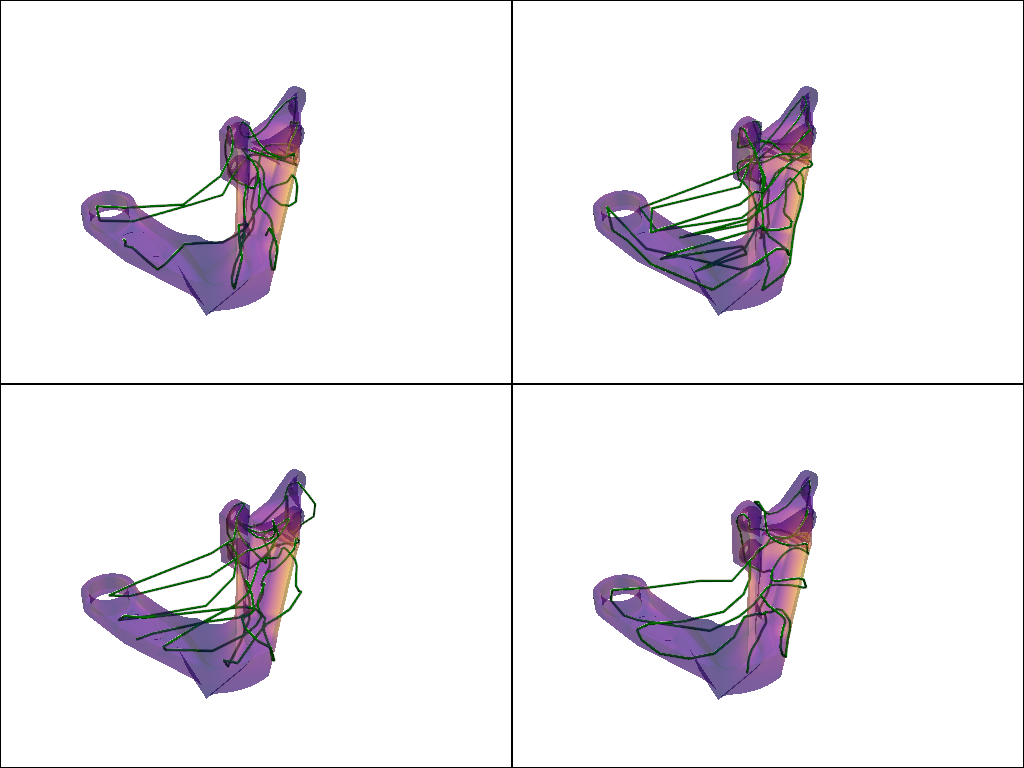

In [56]:
lines = [traj_to_line(traj) for traj in rbf_trajectories]
shape = (2, 2)
pl = pv.Plotter(notebook=True, shape=shape)
opacity = 0.4

for i in range(shape[0]):
    for j in range(shape[1]):
        pl.subplot(i, j)
        line = lines[i * shape[1] + j]
        tube = line.tube(radius=0.0005)
        pl.add_mesh(aero, scalars="von Mises stress", opacity=opacity, cmap=mesh_cmap, show_scalar_bar=False)
        pl.add_mesh(tube, smooth_shading=True, color='green', show_scalar_bar=False)
pl.show(jupyter_backend='pythreejs')

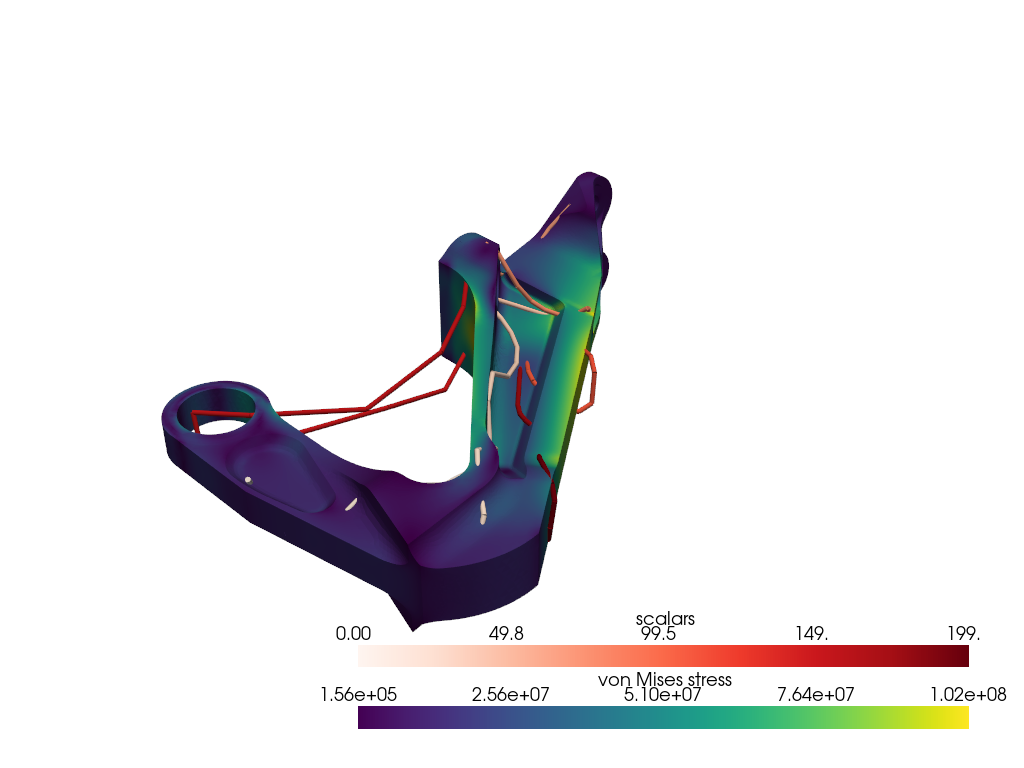

In [32]:
pl = pv.Plotter(notebook=True)


tube = lines[0].tube(radius=0.0005)
pl.add_mesh(aero, scalars="von Mises stress", opacity=1, cmap=mesh_cmap, show_scalar_bar=False)
pl.add_mesh(tube, smooth_shading=True, color="lightgreen", show_scalar_bar=False)
pl.show(jupyter_backend='pythreejs')

### RFF

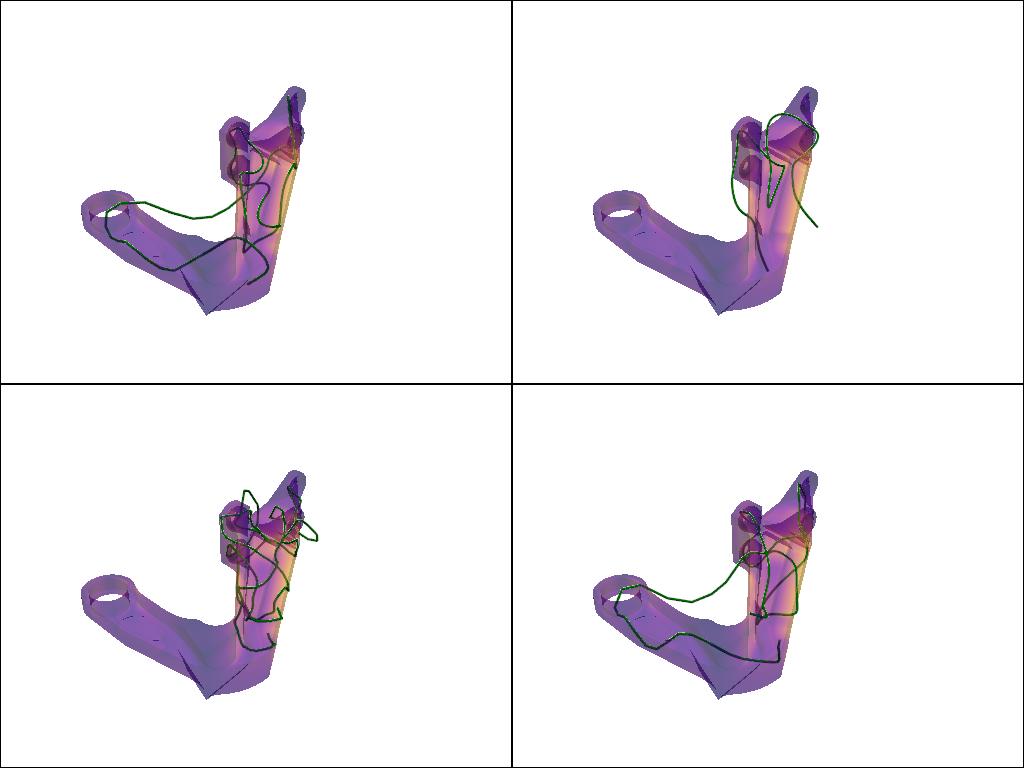

In [43]:
lines = [traj_to_line(traj) for traj in rff_trajectories]
shape = (2, 2)
pl = pv.Plotter(notebook=True, shape=shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        pl.subplot(i, j)
        line = lines[i * shape[1] + j]
        tube = line.tube(radius=0.0005)
        pl.add_mesh(aero, scalars="von Mises stress", cmap=mesh_cmap, opacity=0.4, show_scalar_bar=False)
        pl.add_mesh(tube, smooth_shading=True, color='green', show_scalar_bar=False)
pl.show(jupyter_backend='pythreejs')

### Deep Kernels

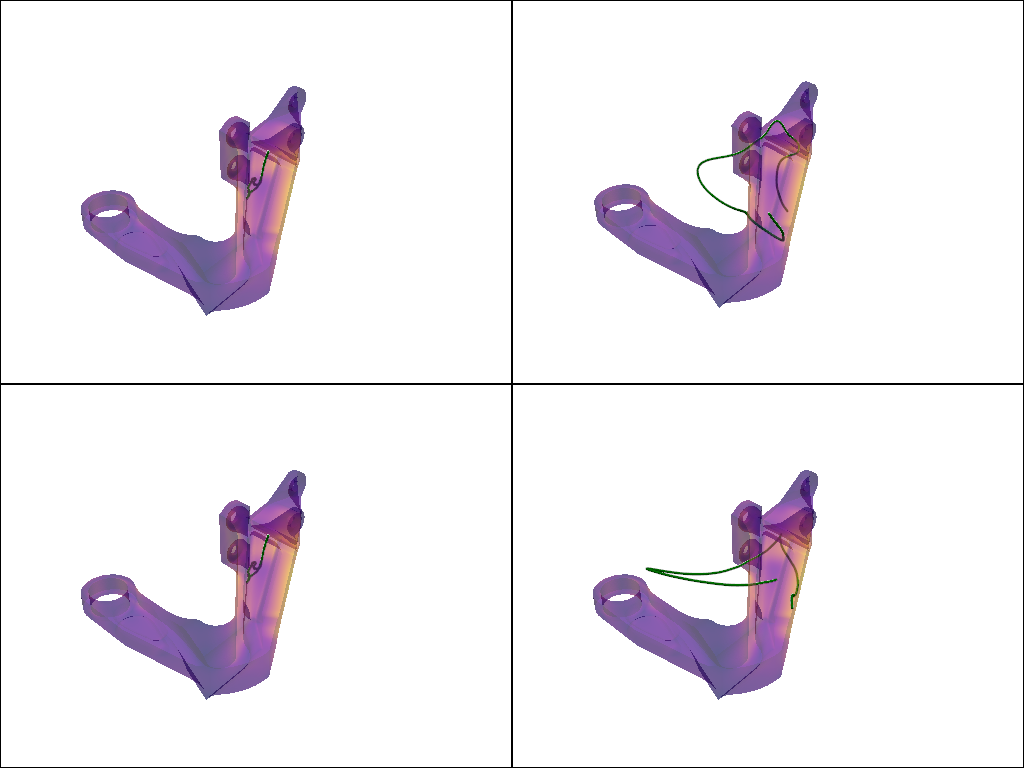

In [55]:
lines = [traj_to_line(traj) for traj in deep_trajectories]
shape = (2, 2)
pl = pv.Plotter(notebook=True, shape=shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        pl.subplot(i, j)
        line = lines[i * shape[1] + j]
        tube = line.tube(radius=0.0005)
        pl.add_mesh(aero, scalars="von Mises stress", cmap=mesh_cmap, opacity=0.4, show_scalar_bar=False)
        pl.add_mesh(tube, smooth_shading=True, color="green")
pl.show(jupyter_backend='pythreejs')

## Metrics

In [105]:
def mse(x, y):
    return jnp.mean((x-y)**2)

### RBF

In [24]:
rbf_init_erg = ergodic_metric(rbf_traj_init.w, bounds, n_modes=20, n_per_dim=60)
rbf_power_erg = ergodic_metric(rbf_power_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_gp_erg = ergodic_metric(rbf_gp_traj.w, bounds, n_modes=20, n_per_dim=60)
rbf_score_erg = ergodic_metric(rbf_score_traj.w, bounds, n_modes=20, n_per_dim=60)

NameError: name 'rbf_traj_init' is not defined

In [123]:
# errors
mse(rbf_init_erg, prob_X_flat), mse(rbf_power_erg, prob_X_flat), \
    mse(rbf_gp_erg, prob_X_flat), mse(rbf_score_erg, prob_X_flat)

(Array(28.25934436, dtype=float64),
 Array(29.97701283, dtype=float64),
 Array(192.97166348, dtype=float64),
 Array(48.23838574, dtype=float64))

## Dev

In [16]:
from emmd.transforms import MultiDeepKernel, MultiDeepCK
from emmd.score import ScoreKernel

In [17]:
mdk = MultiDeepKernel(key, in_dim=3, out_dim=5, d_hidden=15, n_layers=3)
c_mdk = MultiDeepCK(key, in_dim=3, out_dim=5, d_hidden=15, n_layers=3, n_kernels=3)
score = ScoreKernel(key, c_mdk, z=traj_init)

from emmd

In [ ]:
c_mdk(samples, samples)

In [19]:
score.logpdf_q(samples)

Unexpected exception formatting exception. Falling back to standard exceptionUnexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


In [ ]:
G, U, b = score.compute_alpha_params(samples)

In [19]:
score.compute_alpha_params(samples)

Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception
Unexpected exception formatting exception. Falling back to standard exception


ERROR! Session/line number was not unique in database. History logging moved to new session 843
